# Kalman Filter Notebook
This notebook gives an example of the Kalman Filter for sensor fusion. We read light intensity from two noisy [Grove Light Sensors v1.1](https://www.seeedstudio.com/Grove-Light-Sensor-p-746.html), and use the Kalman Filter to estimate the true light intensity. This is achieved by taking a weighted average of estimates and measurements, with more weight being applied to estimates with higher certainty. 

### 1. Record Luminance:
Using PYNQ's base overlay, we can record luminance values from two Grove Light Sensors connected to the board. When the ambient light intensity increases, the resistance of the LDR or Photoresistor will decrease. This means that the output signal from this module will be HIGH in bright light, and LOW in the dark. Values for the sensor ranges from ~5.0 (bright) to >35.0 (dark)

In [1]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")

In this example we have connected LightA and LightB to the PMODA and PMODB interfaces respectively. Given that each sensor produces an analog signal, Grove I2C ADC's are used to bridge between G4 and G3 on the Grove Adapter, and LightA and LightB.

In [2]:
from pynq.lib.pmod import Grove_Light
from pynq.lib.pmod import PMOD_GROVE_G3
from pynq.lib.pmod import PMOD_GROVE_G4

lgtA = Grove_Light(base.PMODA,PMOD_GROVE_G4)
lgtB = Grove_Light(base.PMODB,PMOD_GROVE_G3)

Plot 100 luminance values recorded over 10 seconds:

In [3]:
import time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

lgtA.set_log_interval_ms(100)
lgtB.set_log_interval_ms(100)

lgtA.start_log()
lgtB.start_log()

# Change input during this time
time.sleep(10)
r_log_A = lgtA.get_log()
r_log_B = lgtB.get_log()

Text(0,0.5,'Light Intensity')

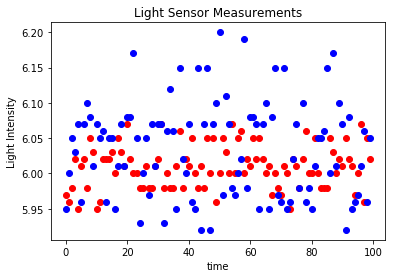

In [9]:
x = np.arange(len(r_log_A))
fig = plt.figure()
ax = fig.gca()
ax.set_title("Light Sensor Measurements")
ax.plot(x, r_log_A, "ro")
ax.plot(x, r_log_B[:len(x)], "bo")
ax.set_xlabel("time")
ax.set_ylabel("Light Intensity")

### 2. Kalman Filter Model

To setup the Kalman Filter, we need to

1. Define the state and input variables
2. Define a state equation which predicts/estimates the next state (denoted **f**)
3. Define an observation equation, relating the state to our measurements (denoted **h**)

Once the system has been described, we are left with two linear gaussian equations (one each for estimations and observations). The Kalman Filter is then used to form a weighted sum of each equation, trading off our uncertainty in each model. Therefore, as a system designer we need to establish whether we are more confident in our state estimation equation, or our measurements. We control this using parameters **qval** and **rval**. As observed in the luminance plot above, our measurements are very noisy for sensor B. Therefore we will chose a large rval for sensor B, indicating higher uncertainty about out those measurements. 


We define the **state** as a vector consisting of the true value and derivative of the luminance. Therefore, number of states **n=2**. Additionally, we only take measurments from two light sensors. Therefore, number of observations **m=2**. Once the state and input variables have been identified, the [PYNQ-EKF build flow](https://github.com/sfox14/pynq-ekf/blob/master/build/build.md) can be used to generate the bitstream (.bit) and library (.so). It is necessary to build new ".bit" and ".so" files for each new configuration of **n=?** and **m=?**, but not for each application. Our KF/EKF architecture implements all application specific code in software.  


### 3. Software Version

In [47]:
from ekf import EKF

class Light_EKF(EKF):

    def __init__(self, n=2, m=2, pval=0.01, qval=0.01, rval=2.5,
                 bitstream=None, lib=None, load_overlay=True):

        EKF.__init__(self, n, m, pval, qval, rval, bitstream, lib, load_overlay)
        self.x = np.array([6.00, 0.1])
        self.x_hw = self.x

        self.n = n
        self.m = m
        
        self.Q = np.eye(self.n)*qval
        self.R = np.eye(self.m)*np.array([0.1,1.0])

    @property
    def ffi_interface(self):
        return

    def run_sw(self, x):
        output = np.zeros(len(x))
        for i, line in enumerate(x):
            # unpack sensor data
            obs = np.array(line).astype(np.float32)
            state = self.step(obs)
            output[i] = state[0]
        return output


    def f(self, x, **kwargs):
        F = np.array([[1, 1], [0, 1]])
        x = np.dot(x, F.T)
        return x, F

    def h(self, x, **kwargs):
        hx = np.array([x[0], x[0]])
        return hx, np.array([[1, 0],[1, 0]])

We can run this and plot the results

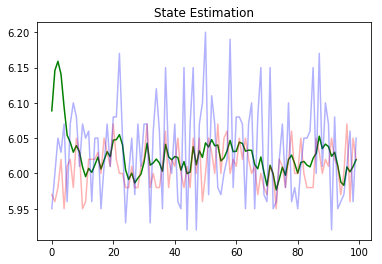

In [50]:
kf = Light_EKF(n=2, m=2, bitstream="ekf.bit", lib="libekf.so")
res_sw = kf.run_sw(data)

plt.figure()
plt.title("State Estimation")
x = np.arange(len(res_sw)) 
plt.plot(x, res_sw, "g")
plt.plot(x, data[:,0], "r", alpha=0.3)
plt.plot(x, data[:,1], "b", alpha=0.3)
plt.show()

### 3. Hardware Version

We chose to only implement the application-independent parts of the algorithm on the FPGA. This gives users the ability to test different system models before deployment. In ekf_notebook.ipynb, we give an example of deploying the entire algorithm to the FPGA.

<img src="imgs/ekf_arch.jpg">